In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [2]:
df = pd.read_csv('bigdata.txt', header=None)

In [3]:
df.values

array([[  44.003316,  167.93424 ],
       [  49.409332,  181.17085 ],
       [  46.469245,  173.13197 ],
       [  49.400011,  180.45534 ],
       [  46.053899,  172.53482 ],
       [  44.235629,  167.98254 ],
       [  51.994983,  186.15658 ],
       [  41.867176,  162.97074 ]])

# Maximum Likelihood Solution

We know that the maximum likelihood solution for this case $w_{ML}$ (obtained by maximizing the log-likelihood function) is equivalent to the least-squares solution $w*$ discussed in Homework 01 (obtained by minimizing the least-squares function). Then, we obtain the solution by solving $(X^TX)^{-1}X^TY$

In [36]:
def ml_solution(X, t):
    xxt = np.dot(np.transpose(X), X)
    inv = np.linalg.inv(xxt)
    X_factor = np.dot(inv, np.transpose(X))
    return np.dot(X_factor, t)

In [22]:
X = np.zeros((len(df.values),2))
X[:, 0] = 1.
X[:, 1] = df[0].values
t = df[1].values
X, t

(array([[  1.      ,  44.003316],
        [  1.      ,  49.409332],
        [  1.      ,  46.469245],
        [  1.      ,  49.400011],
        [  1.      ,  46.053899],
        [  1.      ,  44.235629],
        [  1.      ,  51.994983],
        [  1.      ,  41.867176]]),
 array([ 167.93424,  181.17085,  173.13197,  180.45534,  172.53482,
         167.98254,  186.15658,  162.97074]))

In [23]:
wml = ml_solution(X, t)
wml

array([ 63.05417186,   2.37750613])

The value of $\sigma_{ML}$ for this distribution is found from the mean squared error of the model using $w_{ML}$

In [24]:
def predict(x, w):
    return w[0] + w[1]*x

def mse(X, t, w):
    s = sum([(predict(x, w) - y)**2 for x,y in zip(X,t)])/len(X)
    return s
    
cov_ml = np.eye(2)*mse(df[0].values, df[1].values, wml)

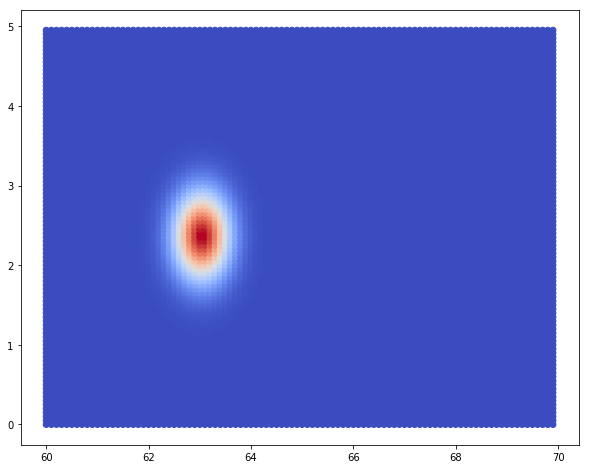

In [25]:
x = np.array([(x,y) for x in np.arange(60, 70, 0.1) for y in np.arange(0, 5, 0.05)])
dist = stats.multivariate_normal.pdf(x, mean=wml, cov=cov_ml)

plt.figure(figsize=(10,8))
plt.scatter([p[0] for p in x], [p[1] for p in x], c=dist, cmap=mpl.cm.coolwarm)

Taking samples from the distribution $N(w_{ML}, \sigma_{ML}I)$, we get

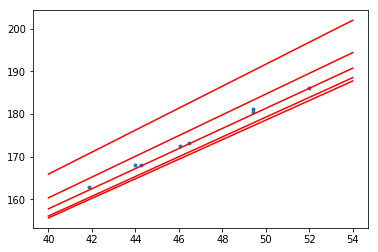

In [27]:
samples = []
for _ in range(5):
    samples.append(stats.multivariate_normal.rvs(mean=wml, cov=cov_ml))

plt.plot(df[0].values, df[1].values, '.')
pos = [x for x in range(40, 55)]
pos
for sample in samples:
    plt.plot(pos, [sample[0] + sample[1]*x for x in pos], 'r')

# Batch Bayesian Estimate

To make it bayesian, we must introduce a prior distribution over the parameters of the distribution. Our prior will be a gaussian $N(m_0, \alpha^{-1} I)$. We will use $m_0 = (n, m)^T$ where $m = \frac{t_7 - t_8}{x_7 - x_8}$ and $n = t_7 - mx_7$ where $(x_7, t_7)$ and $(x_8, t_8)$ are the seventh and eighth points in the dataset (respectively, the point with the largest coordinates and the one with the lowest). 

As for the precision, we will use $\alpha^{-1} = \frac{1}{N} \sum\limits_{k=1}^{N} (p(x_k) - t_k)^2$, where $p(x) = mx + n$ (i.e. $\alpha^{-1}$ is the mean squared error if we were to use the line between points 7 and 8 as model). The prior distribution is

array([[ 0.15543014,  0.        ],
       [ 0.        ,  0.15543014]])

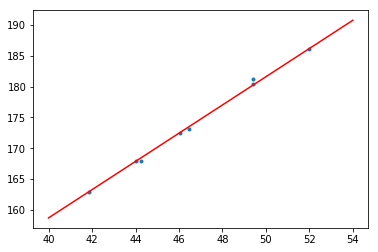

In [28]:
m = (df[1][7] - df[1][6])/(df[0][7] - df[0][6])
n = df[1][7] - m*df[0][7]

plt.plot(df[0].values, df[1].values, '.')
plt.plot(pos, [n + m*x for x in pos], 'r')

cov = mse(df[0].values, df[1].values, np.array([n, m]))*np.eye(2)
cov

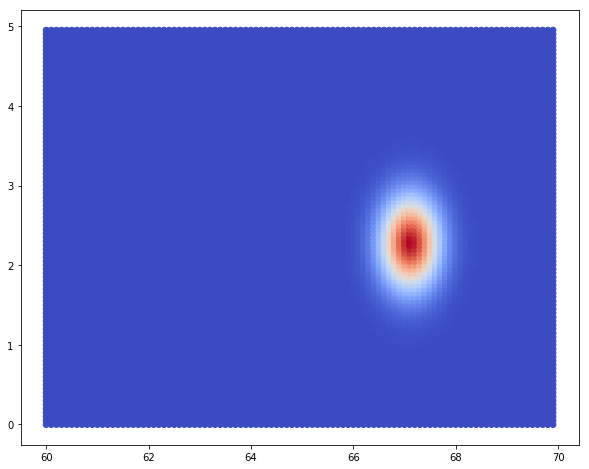

In [29]:
x = np.array([(x,y) for x in np.arange(60, 70, 0.1) for y in np.arange(0, 5, 0.05)])
dist = stats.multivariate_normal.pdf(x, mean=[n,m], cov=cov)

plt.figure(figsize=(10,8))
plt.scatter([p[0] for p in x], [p[1] for p in x], c=dist, cmap=mpl.cm.coolwarm)

In [30]:
def cov_posteriori(cov_prior, phi, beta_ml):
    # computes (S0ˆ-1 + beta*phi^T*phi)ˆ-1
    invcov = np.linalg.inv(cov_prior)
    phitphi = np.dot(np.transpose(phi), phi)
    plus = np.dot(beta_ml, phitphi)
    return np.linalg.inv(invcov + plus)

def w_posteriori(phi, t, cov_prior, mean_prior, cov_posteriori, beta_ml):
    # computes Sn*(S0^-1 * m0 + beta*phi^T*t)
    prior_factor = np.dot(np.linalg.inv(cov_prior), mean_prior)
    betaphi = np.dot(beta_ml, np.transpose(phi))
    betaphi_t = np.dot(betaphi, t)
    parenthesis = prior_factor + betaphi_t
    return np.dot(cov_posteriori, parenthesis)

In [31]:
cp = cov_posteriori(cov, X, cov_ml*np.eye(2))
wp = w_posteriori(X, t, cov, np.array([n, m]), cp, cov_ml*np.eye(2))

print(cp)
print(wp)

[[ 0.1552368  -0.00330176]
 [-0.00330176  0.00047796]]
[ 67.12135255   2.29076923]


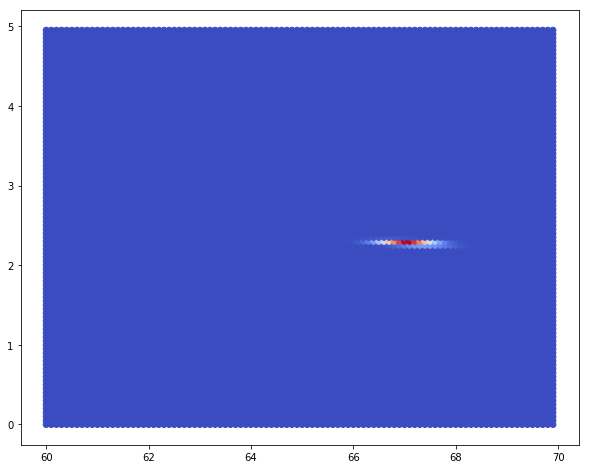

In [32]:
x = np.array([(x,y) for x in np.arange(60, 70, 0.1) for y in np.arange(0, 5, 0.05)])
dist = stats.multivariate_normal.pdf(x, mean=wp, cov=cp)

plt.figure(figsize=(10,8))
plt.scatter([p[0] for p in x], [p[1] for p in x], c=dist, cmap=mpl.cm.coolwarm)

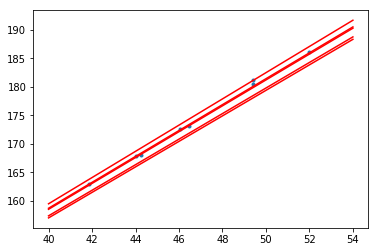

In [33]:
samples = []
for _ in range(5):
    samples.append(stats.multivariate_normal.rvs(mean=wp, cov=cp))

plt.plot(df[0].values, df[1].values, '.')
pos = [x for x in range(40, 55)]
pos
for sample in samples:
    plt.plot(pos, [sample[0] + sample[1]*x for x in pos], 'r')

# Sequential Bayesian Estimate

Now we must calculate a posterior distribution for a sequential dataset, i.e, at every step we add a new point from the total dataset and calculate a posterior distribution. The prior used will be the same as in the batch estimate.

In [37]:
def sequential_estimate(X, t, w_prior, cov_prior):
    params = []
    cp, wp = cov_prior, w_prior
    
    points, targets = [], []
    
    for point, target in zip(X, t):
        points.append(point)
        targets.append(target)
        param = {}
        param.update({'prior': (wp, cp)})
                
        w_ml = ml_solution(np.array(points), np.array(targets))
        cov_ml = mse(np.array(points), np.array(targets), w_ml)
        
        param.update({'likelihood': (w_ml, cov_ml)})
        
        cp = cov_posteriori(param['prior'][1], point, cov_ml*np.eye(2))
        wp = w_posteriori(point, target, param['prior'][1], param['prior'][0], cp, cov_ml*np.eye(2))
        
        param.update({'posterior': (wp, cp)})
    
        params.append(param)
    
    return params
        
        
        
outs = sequential_estimate(X, df[1].values, np.array([n, m]), cov)

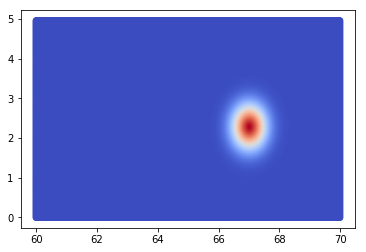

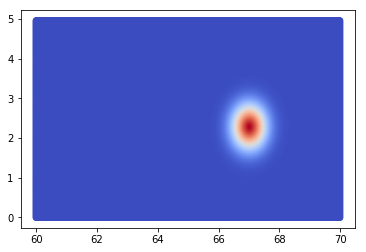

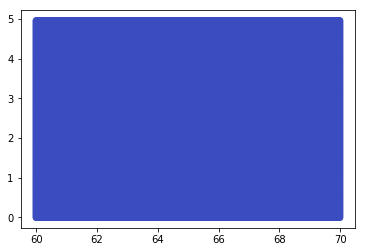

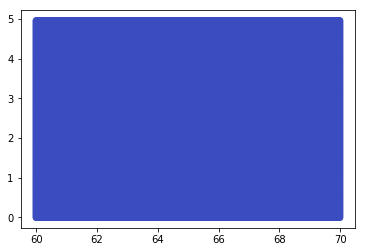

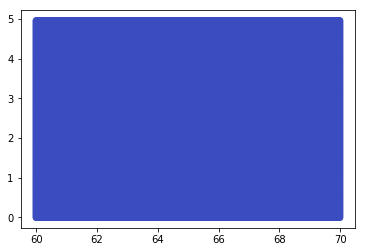

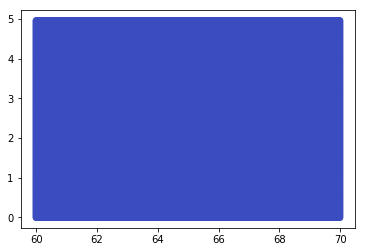

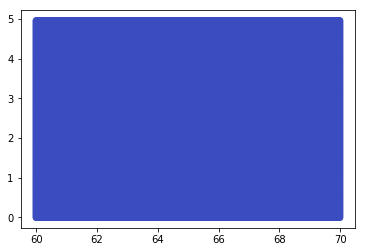

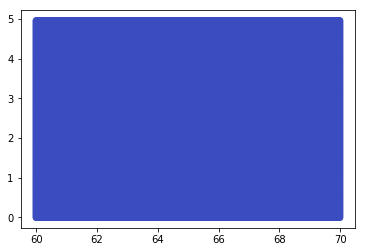

In [38]:
#fig = plt.figure(figsize=(25, 20))

for it in outs:
    #f, grid = plt.subplots(3, 1, sharex=True)
    x = np.array([(x,y) for x in np.arange(60, 70, 0.01) for y in np.arange(0, 5, 0.05)])
    dist = stats.multivariate_normal.pdf(x, mean=it['prior'][0], cov=it['prior'][1])

    plt.scatter([p[0] for p in x], [p[1] for p in x], c=dist, cmap=mpl.cm.coolwarm)
    plt.show()